<a href="https://colab.research.google.com/github/palis-dev/jupyter-notebooks/blob/main/ml_regressao_logistica_senioridade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy  táas np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
num_classes = 3
class_names = ['Junior', 'Pleno', 'Sênior']
feature_names = [
  'commits_por_ano',
  'tempo_de_carreira',
  'tasks_finalizadas'
]

X, y = make_classification(n_samples=500,
                           n_features=3,
                           n_informative=3,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           n_classes=num_classes,
                           random_state=42)
# NORMALIZAÇÃO DOS DADOS
X = X - X.min(axis=0) + 1
escala = 10
X = np.round(X * escala).astype(int)
offset_pleno = 20
offset_senior = 40
X[y == 1, 1:3] += offset_pleno
X[y == 2, 1:3] += offset_senior

intervalos = {
    0: (1, 7),
    1: (8, 14),
    2: (15, 20)
}

X_final = X.copy()

for classe in range(num_classes):
    low, high = intervalos[classe]
    mask = (y == classe)
    career = X[mask, 1].astype(float)
    career_norm = (career - career.min()) / (career.max() - career.min() + 1e-6)
    career_mapped = low + career_norm * (high - low)
    X_final[mask, 1] = np.round(career_mapped).astype(int)

X = X_final.copy()

X_train_orig, X_test_orig, y_train, y_test = \
train_test_split(X, y,
                 test_size=0.2,
                 random_state=42
                 )

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_orig)
X_test = scaler.transform(X_test_orig)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
input_dim = X_train_tensor.shape[1]

model = nn.Linear(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}")

model.eval()

Epoch 20/200 - Loss: 0.5650
Epoch 40/200 - Loss: 0.4038
Epoch 60/200 - Loss: 0.3300
Epoch 80/200 - Loss: 0.2861
Epoch 100/200 - Loss: 0.2562
Epoch 120/200 - Loss: 0.2339
Epoch 140/200 - Loss: 0.2163
Epoch 160/200 - Loss: 0.2020
Epoch 180/200 - Loss: 0.1899
Epoch 200/200 - Loss: 0.1796


Linear(in_features=3, out_features=3, bias=True)

In [ ]:
import pandas as pd
df = pd.DataFrame(X_train, columns=feature_names)
df.head()

,commits_por_ano,tempo_de_carreira,tasks_finalizadas
0,0.996715,0.209714,0.476305
1,-0.095775,0.744016,0.677862
2,0.559719,0.031613,1.332924
3,-0.459938,-0.324589,0.274748
4,0.923882,0.209714,0.577084


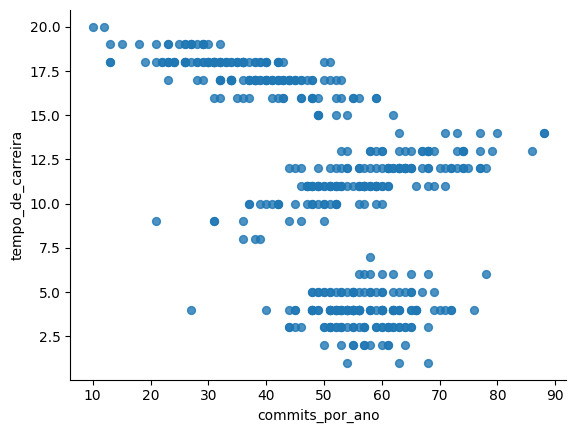

In [ ]:
# @title commits_por_ano vs tempo_de_carreira

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='commits_por_ano', y='tempo_de_carreira', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import plotly.express as px
import pandas as pd

df_train = pd.DataFrame(X_train_orig, columns=['Commits no Ano', 'Tempo de Carreira', 'Tasks Finalizadas'])
df_train['Classe'] = [class_names[label] for label in y_train]

fig = px.scatter_3d(df_train,
                    x='Commits no Ano',
                    y='Tempo de Carreira',
                    z='Tasks Finalizadas',
                    color='Classe',
                    title='Dados de Treino em 3D - Interativo')
fig.show()


In [ ]:
with torch.no_grad():
    test_outputs = model(X_test_tensor)

    test_loss = criterion(test_outputs, y_test_tensor)

    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).float().mean()

    print(f"\nTest Loss: {test_loss.item():.4f} - Test Accuracy: {accuracy.item() * 100:.2f}%")

print("\nExemplos de predições:")
for i in range(10):
    true_name = class_names[y_test[i]]
    pred_name = class_names[predicted[i]]
    print(f"Amostra {i}: Verdadeiro: {true_name}, Predito: {pred_name}")



Test Loss: 0.1761 - Test Accuracy: 97.00%

Exemplos de predições:
Amostra 0: Verdadeiro: Sênior, Predito: Sênior
Amostra 1: Verdadeiro: Junior, Predito: Junior
Amostra 2: Verdadeiro: Pleno, Predito: Pleno
Amostra 3: Verdadeiro: Pleno, Predito: Pleno
Amostra 4: Verdadeiro: Junior, Predito: Junior
Amostra 5: Verdadeiro: Junior, Predito: Junior
Amostra 6: Verdadeiro: Junior, Predito: Junior
Amostra 7: Verdadeiro: Sênior, Predito: Sênior
Amostra 8: Verdadeiro: Sênior, Predito: Sênior
Amostra 9: Verdadeiro: Pleno, Predito: Pleno


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

def plot_vectors(angleA=0, magA=3, angleB=45, magB=4):
    # Converte os ângulos de graus para radianos
    radA = np.deg2rad(angleA)
    radB = np.deg2rad(angleB)

    # Define os vetores A e B em 2D
    A = np.array([magA * np.cos(radA), magA * np.sin(radA)])
    B = np.array([magB * np.cos(radB), magB * np.sin(radB)])

    # Calcula o ângulo delta absoluto entre os dois vetores
    delta = np.abs(radB - radA)
    delta_deg = np.rad2deg(delta)

    # Cria o gráfico
    plt.figure(figsize=(6,6))
    # Plota o vetor A (vermelho) e o vetor B (azul)
    plt.quiver(0, 0, A[0], A[1], angles='xy', scale_units='xy', scale=1, color='r', label="Vetor A")
    plt.quiver(0, 0, B[0], B[1], angles='xy', scale_units='xy', scale=1, color='b', label="Vetor B")

    # Para exibir o ângulo, desenha um arco com raio ajustável
    r = 0.5 * min(magA, magB)
    # Cria uma sequência de ângulos entre os dois vetores
    theta = np.linspace(radA, radB, 100) if radA < radB else np.linspace(radB, radA, 100)
    plt.plot(r * np.cos(theta), r * np.sin(theta), 'k--', label=f"δ = {delta_deg:.1f}°")

    # Define limites e rótulos do gráfico
    lim = max(magA, magB) + 1
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Visualização dos vetores A e B e o ângulo δ")
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Cria sliders interativos para modificar os parâmetros dos vetores
widgets.interact(
    plot_vectors,
    angleA=widgets.FloatSlider(min=-180, max=180, step=1, value=0, description="Ângulo A (°)"),
    magA=widgets.FloatSlider(min=0.1, max=10, step=0.1, value=3, description="Magnitude A"),
    angleB=widgets.FloatSlider(min=-180, max=180, step=1, value=45, description="Ângulo B (°)"),
    magB=widgets.FloatSlider(min=0.1, max=10, step=0.1, value=4, description="Magnitude B")
)


interactive(children=(FloatSlider(value=0.0, description='Ângulo A (°)', max=180.0, min=-180.0, step=1.0), Flo…

<function __main__.plot_vectors(angleA=0, magA=3, angleB=45, magB=4)>